# Tutorial for Implementing a Global NeuralProphet Model

***
***

The repository and documentation for `NeuralProphet` can be found [here](https://github.com/ourownstory/neural_prophet) and [here](https://neuralprophet.com/html/contents.html).

This file is based on code from a [tutorial](https://github.com/ourownstory/neural_prophet/blob/main/tutorials/feature-use/global_modeling.ipynb) on implementing a global model in NeuralProphet.

In [1]:
# general modules
import pandas as pd

# import NeuralProphet model, functions to set log level and random seed
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed

# set random seed and log level
set_random_seed(10)
set_log_level("ERROR", "INFO")

In [2]:
# download energy dataset, view first few rows
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df_ercot = pd.read_csv(data_location + "energy/price_ercot_dam.csv")
df_ercot.head()

,ds,y,temp_celsius_houston
0,2015-01-01 00:00:00,22.01,7.96
1,2015-01-01 01:00:00,21.39,7.45
2,2015-01-01 02:00:00,21.00,7.10
3,2015-01-01 03:00:00,20.72,7.05
4,2015-01-01 04:00:00,21.18,6.60


In [3]:
# store column names
var_names = list(df_ercot)[1:]

In [4]:
var_names

['y', 'temp_celsius_houston']

In [5]:
# dictionary to store dataframe for each series
df_dict = {}

# for each series,
for name in var_names:
    # select date variable and target variable
    aux = df_ercot[['ds', name]].copy()
    #rename column of data to 'y' which is compatible with Neural Prophet
    aux = aux.rename(columns = {name: 'y'})
    # store data in df_dict with column name as key
    df_dict[name] = aux

### Global Model with Global Normalization

In [6]:
# instantiate NeuralProphet model using 24 lags and global normalization (each series is normalized using global params)
m = NeuralProphet(n_lags=24, global_normalization=True)

In [7]:
# create train and test dictionaries split locally (split each dataframe in dict), 
# where test is 20% of data,
# and specify hourly frequency
df_train_dict, df_test_dict = m.split_df(df_dict, freq="H", valid_p = 0.20, local_split = True)

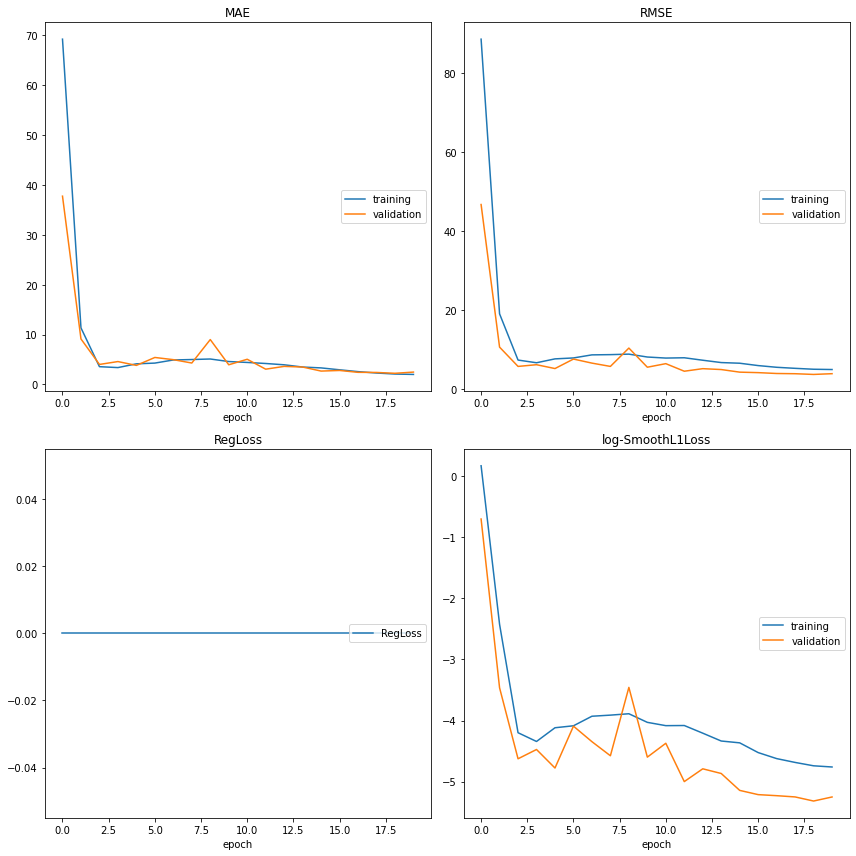

MAE
	training         	 (min:    2.015, max:   69.262, cur:    2.015)
	validation       	 (min:    2.245, max:   37.771, cur:    2.485)
RMSE
	training         	 (min:    5.003, max:   88.625, cur:    5.003)
	validation       	 (min:    3.760, max:   46.771, cur:    3.949)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	training         	 (min:   -4.760, max:    0.172, cur:   -4.760)
	validation       	 (min:   -5.317, max:   -0.700, cur:   -5.251)


In [8]:
# fit the model on the training data,
# use test data as validation set,
# plot training progress using MAE, RMSE, and log-loss
metrics = m.fit(df_train_dict, validation_df=df_test_dict, progress="plot-all")

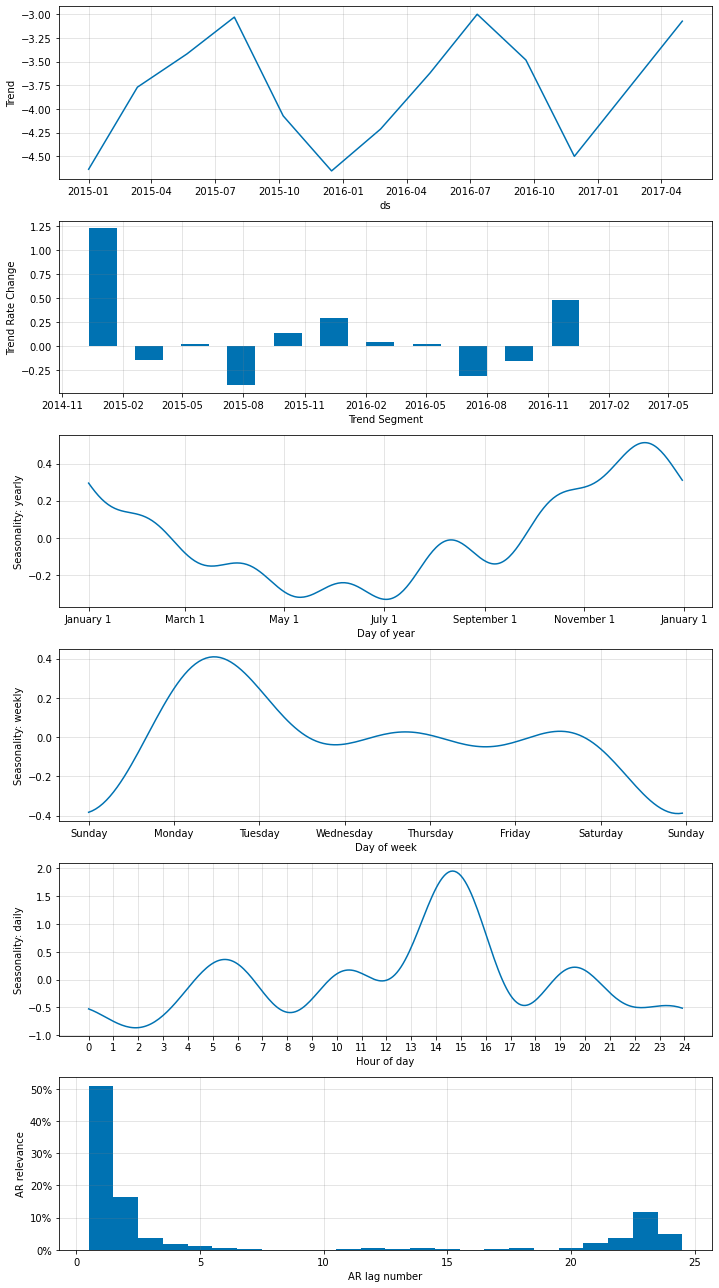

In [9]:
# plot model parameters
fig_param = m.plot_parameters()

In [10]:
# calculate accuracy metrics for the test data
test_metrics = m.test(df_test_dict)
test_metrics

,SmoothL1Loss,MAE,RMSE
0,0.005242,2.485406,3.948565


In [11]:
# make dataframe with rows for the future built from the test data
# default is one-step ahead
# include predicted values for all the test data using n_historic_predictions=True
future = m.make_future_dataframe(df_test_dict, n_historic_predictions=True)

In [12]:
# show future dataframe with one new row
future['y']

,ds,y
0,2017-04-30 11:00:00,31.03
1,2017-04-30 12:00:00,36.28
2,2017-04-30 13:00:00,37.41
3,2017-04-30 14:00:00,42.45
4,2017-04-30 15:00:00,39.84
...,...,...
5122,2017-11-29 21:00:00,23.55
5123,2017-11-29 22:00:00,22.41
5124,2017-11-29 23:00:00,19.64
5125,2017-11-30 00:00:00,18.40


In [13]:
# make predictions for past values and one-step-ahead
m.predict(future)['y'].iloc[23:,:]

,ds,y,yhat1,residual1,ar1,trend,season_yearly,season_weekly,season_daily
23,2017-05-01 10:00:00,22.82,None,NaN,None,None,None,None,None
24,2017-05-01 11:00:00,28.90,27.044298,-1.855702,29.892311,-3.073013,-0.293903,0.408621,0.11028
25,2017-05-01 12:00:00,30.94,32.649223,1.709223,35.619911,-3.072629,-0.294133,0.408091,-0.012016
26,2017-05-01 13:00:00,39.95,34.754326,-5.195674,37.133385,-3.072244,-0.294363,0.405064,0.582479
27,2017-05-01 14:00:00,48.25,43.601524,-4.648476,44.924053,-3.07186,-0.294591,0.399635,1.644293
...,...,...,...,...,...,...,...,...,...
5122,2017-11-29 21:00:00,23.55,26.336884,2.786884,27.184078,-1.112679,0.483018,0.020925,-0.238462
5123,2017-11-29 22:00:00,22.41,24.687784,2.277784,25.793945,-1.112294,0.483303,0.017908,-0.495075
5124,2017-11-29 23:00:00,19.64,23.53154,3.89154,24.618919,-1.11191,0.483587,0.014329,-0.473385
5125,2017-11-30 00:00:00,18.40,21.18667,2.78667,22.33095,-1.111525,0.483869,0.010258,-0.52688


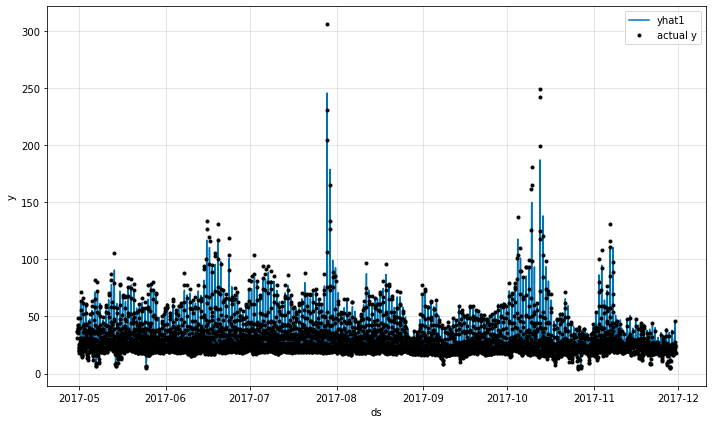

In [14]:
# combine previous steps and plot predicted and actual values
future = m.make_future_dataframe(df_test_dict, n_historic_predictions = True)
forecast = m.predict(future)
fig = m.plot(forecast['y'])

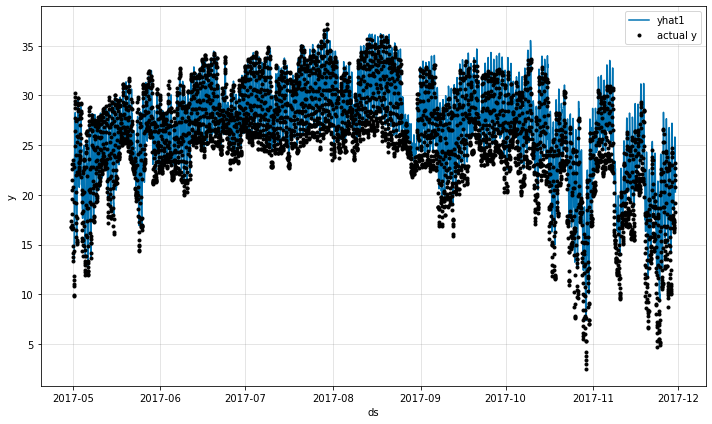

In [15]:
fig = m.plot(forecast['temp_celsius_houston'])

***

### Global Model with Local Normalization

In [16]:
# instantiate NeuralProphet model using 24 lags and local normalization (each series is normalized using global params)
m = NeuralProphet(n_lags=24, global_normalization=False)

In [17]:
# create train and test dictionaries split locally (split each dataframe in dict), 
# where test is 20% of data,
# and specify hourly frequency
df_train_dict, df_test_dict = m.split_df(df_dict, freq="H", valid_p = 0.20, local_split = True)

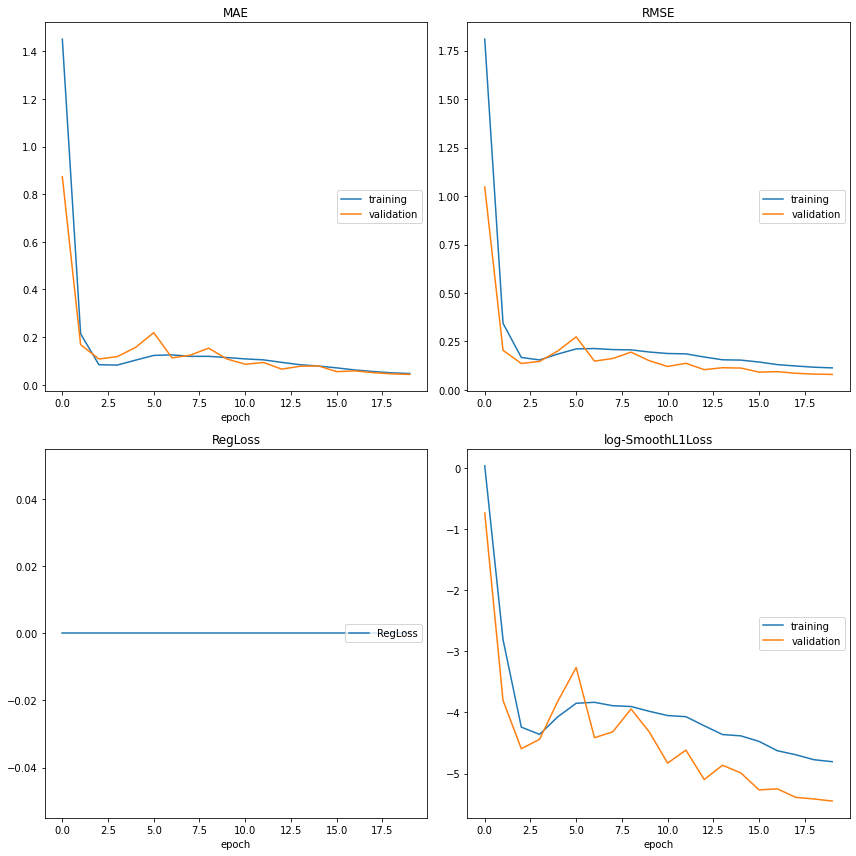

MAE
	training         	 (min:    0.047, max:    1.451, cur:    0.047)
	validation       	 (min:    0.043, max:    0.873, cur:    0.043)
RMSE
	training         	 (min:    0.114, max:    1.809, cur:    0.114)
	validation       	 (min:    0.080, max:    1.047, cur:    0.080)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	training         	 (min:   -4.805, max:    0.033, cur:   -4.805)
	validation       	 (min:   -5.449, max:   -0.740, cur:   -5.449)


In [18]:
# fit the model on the training data,
# use test data as validation set,
# plot training progress using MAE, RMSE, and log-loss
metrics = m.fit(df_train_dict, validation_df=df_test_dict, progress="plot-all")

In [19]:
# calculate accuracy metrics for the test data
# metrics are for normalized data when global normalization is not used
test_metrics = m.test(df_test_dict)
test_metrics

,SmoothL1Loss,MAE,RMSE
0,0.004303,0.043262,0.079872


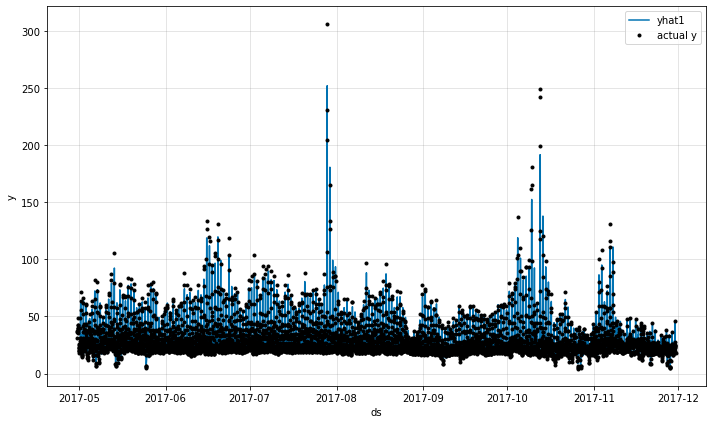

In [20]:
# make historic predictions
# plot forecasts for y
future = m.make_future_dataframe(df_test_dict, n_historic_predictions = True)
forecast = m.predict(future)
fig = m.plot(forecast['y'])

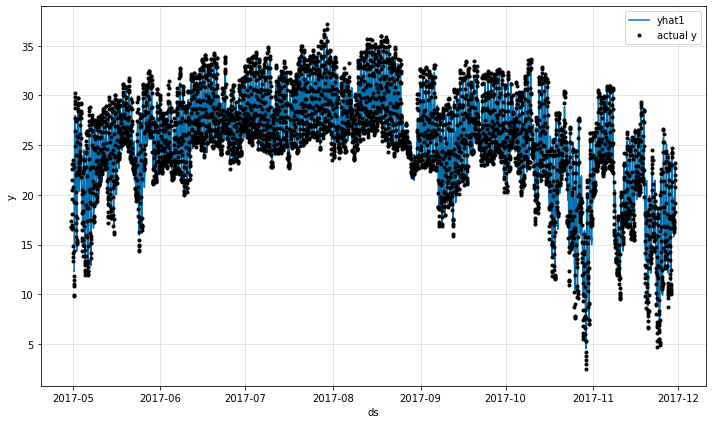

In [21]:
# plot forecasts for celcius temperature in houston
fig = m.plot(forecast['temp_celsius_houston'])